## CIFAR Using CNN 

#### Ahmad Pouramini, Benyamin Hosseini 

---



This is the implementatin of CIFAR using CNN.

Source: https://blog.plon.io/tutorials/cifar-10-classification-using-keras-tutorial/

Other Sources: https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/

Question PDF: https://drive.google.com/open?id=1sySPwALk8alK38ejbjCoN5fS_YSHaBPs


## Loading Data

Using TensorFlow backend.


Found GPU at:/device:GPU:0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: This function is deprecated. Please call randint(0, 999 + 1) instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: DeprecationWarning: This function is deprecated. Please call randint(0, 999 + 1) instead


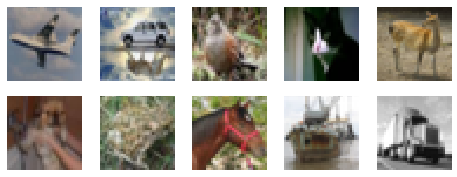

In [3]:
# Import all modules
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
# from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp

# Loading the CIFAR-10 datasets
from keras.datasets import cifar10

# GPU Processing
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at:{}'.format(device_name))

batch_size = 32 
# 32 examples in a mini-batch, smaller batch size means more updates in one epoch
 
num_classes = 10 #
epochs = 100 # repeat 100 times

(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

# Reduce data to 500 train samples and 100 test samples
x_train2=[]
y_train2=[]
for i in range(num_classes):
  c,_=np.where(y_train==i)
  tr_samples = np.random.random_integers(0,len(c)-1,500) # Choose 500 random samples for train data
  x_train_i = x_train[c[tr_samples],:,:]
  y_train_i = y_train[c[tr_samples],:]
  x_train2.append(x_train_i)
  y_train2.append(y_train_i)

y_train2=np.concatenate([y_train2[i]
                         for i in range(num_classes)])
x_train2=np.concatenate([x_train2[i]
                         for i in range(num_classes)])

x_test2=[]
y_test2=[]
for i in range(num_classes):
  c,_=np.where(y_test==i)
  te_samples = np.random.random_integers(0,len(c)-1,100) # Choose 100 random samples for test data
  x_test_i = x_test[c[te_samples],:,:]
  y_test_i = y_test[c[te_samples],:]
  x_test2.append(x_test_i)
  y_test2.append(y_test_i)

y_test2=np.concatenate([y_test2[i]
                         for i in range(num_classes)])
x_test2=np.concatenate([x_test2[i]
                         for i in range(num_classes)])

tr_shuffle = np.random.random_integers(0,len(y_train2)-1,len(y_train2))
te_shuffle = np.random.random_integers(0,len(y_test2)-1,len(y_test2))

x_train = x_train2 [tr_shuffle,:,:]
y_train = y_train2[tr_shuffle,:]

x_test = x_test2 [te_shuffle,:,:]
y_test = y_test2[te_shuffle,:]

# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1)
# x_train - training data(images), y_train - labels(digits)

# Print figure with 10 random images from each
 
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(1,2,0))
#   ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()


## Data Normalization

In [0]:
# Convert and pre-processing

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
#y_valid = np_utils.to_categorical(y_valid, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_valid = x_valid.astype('float32')
x_train  /= 255
x_test /= 255
#x_valid /= 255


## Creating the base model

In [0]:
# Based on:
# github.com/abhijeet3922/Object-recognition-CIFAR-10/blob/master/cifar10.py

def base_model():  # 3 Convolutional layers + 1 hidden layer MLP
    model = Sequential()
   
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'))  # first layer filters: 32 filters 3x3
    #model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3), activation='relu'))  # second layer filters: 32 filters 3x3
    model.add(MaxPooling2D(pool_size=(2, 2)))  # second layer pooling: max pooling 2x2

    model.add(Conv2D(64, (3, 3), activation='relu'))  # third layer filters: 64 filters 3x3
    model.add(MaxPooling2D(pool_size=(2, 2)))  # third layer pooling: max pooling 2x2

    # MLP
    model.add(Flatten())
    #model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu',kernel_constraint=maxnorm(3)))  # MLP first hidden layer neurons
    #model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))  # MLP output layer neurons
    
    epochs = 20 
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, decay=decay, momentum=0.9, nesterov=False)  # sigmoid optimizer

    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

## The model summary

In [6]:
cnn_n = base_model()
cnn_n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 30, 30)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 13, 13)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 6, 6)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1180160   
__________

## Training the Model

In [8]:
epochs = 20
cnn = cnn_n.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=32)
scores = cnn_n.evaluate(x_test,y_test,verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 2s 387us/step - loss: 1.9395 - acc: 0.2860 - val_loss: 1.7540 - val_acc: 0.3910
Epoch 2/20
5000/5000 [==============================] - 2s 378us/step - loss: 1.6718 - acc: 0.4018 - val_loss: 1.6172 - val_acc: 0.4220
Epoch 3/20
5000/5000 [==============================] - 2s 374us/step - loss: 1.4189 - acc: 0.4934 - val_loss: 1.4944 - val_acc: 0.4790
Epoch 4/20
5000/5000 [==============================] - 2s 366us/step - loss: 1.2077 - acc: 0.5798 - val_loss: 1.7276 - val_acc: 0.4280
Epoch 5/20
5000/5000 [==============================] - 2s 366us/step - loss: 0.9234 - acc: 0.6900 - val_loss: 1.6107 - val_acc: 0.4820
Epoch 6/20
5000/5000 [==============================] - 2s 374us/step - loss: 0.6652 - acc: 0.7830 - val_loss: 1.7482 - val_acc: 0.4990
Epoch 7/20
5000/5000 [==============================] - 2s 370us/step - loss: 0.4218 - acc: 0.8640 - val_loss: 2.1186 - val_acc: 0.4710


## Results

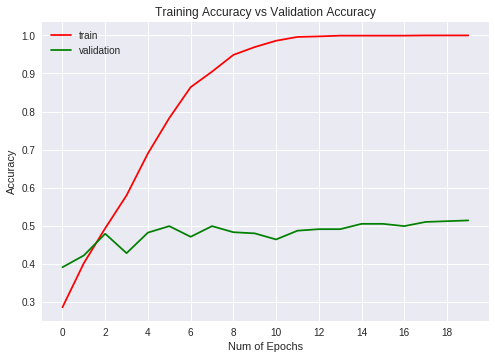

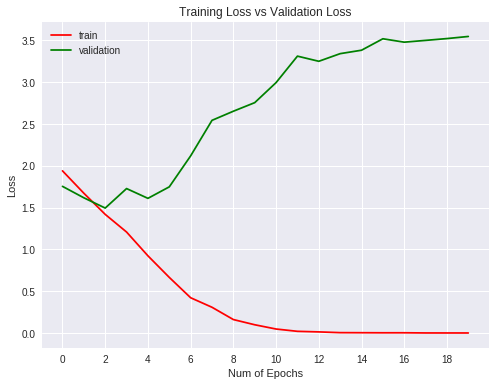

Accuracy: 51.40%
0 107
1 90
2 94
3 93
4 94
5 107
6 113
7 110
8 90
9 102
[[70  3  3  2  9  1  1  3 15  0]
 [ 4 54  0  0  1  1  1  1  6 22]
 [13  2 31 12 10  9  3 11  3  0]
 [ 1  1  5 24 13 17  8 13  4  7]
 [15  1  4  4 46  3 11  9  1  0]
 [ 1  5  8 18  7 37 15 12  0  4]
 [ 2  1 11  9  2  3 72  0  4  9]
 [ 1  0 14  6 10  6  2 59  5  7]
 [ 8  4  4  3  0  1  0  0 69  1]
 [ 5 11 11  4  7  1  7  1  3 52]]


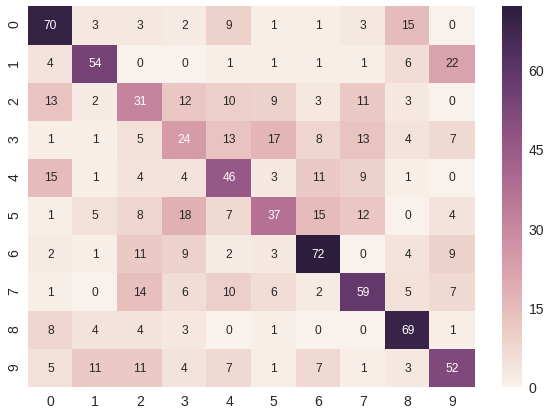

In [9]:
plt.figure(0)
plt.plot(cnn.history['acc'],'r')
plt.plot(cnn.history['val_acc'],'g')
plt.xticks(np.arange(0, epochs, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, epochs, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
 
plt.show()

scores = cnn_n.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred1 = cnn_n.predict(x_test, verbose=2)
y_pred1 = np.argmax(Y_pred1, axis=1)

for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred1)[ix].sum())
cm1 = confusion_matrix(np.argmax(y_test,axis=1),y_pred1)
print(cm1)

# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm1 = pd.DataFrame(cm1, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm1, annot=True,annot_kws={"size": 12})# font size
plt.show()

